## Introduction

### In this notebook we use [SRGAN](https://arxiv.org/abs/1609.04802) to perform Super Resolution

### Libraries 📚⬇

In [1]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19,VGG19_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import cv2

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
# import warnings
# warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from torchinfo import summary

### Create Metadata
set use_set{x} to True or False to select data to train with

In [3]:
main_path = '/kaggle/input'
set2_path = '/kaggle/input/chest-ctscan-images/Data'
set3_path = '/kaggle/input/sarscov2-ctscan-dataset'
set4_path = '/kaggle/input/chest-ctscan-images/Data'
set5_path = '/kaggle/input/animals10/raw-img'
use_set2 = True
use_set3 = True
use_set4 = True
use_set5 = False # Big set, adds a lot of training time

In [4]:
meta_handler = [(use_set2,set2_path),(use_set3,set3_path),(use_set4,set4_path),(use_set5,set5_path)]

filepaths = []
from_dataset = []
for i,(b, path) in enumerate(meta_handler):
    if not b:
        continue

    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('.tif') or filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg') :
                filepath = os.path.join(dirname, filename)
                filepaths.append(filepath)
                from_dataset.append(i)

metadata = pd.DataFrame({'filepaths':filepaths,'from_dataset':from_dataset })
print(metadata.shape)
metadata.head()

(4481, 2)


filepaths  from_dataset
0  /kaggle/input/chest-ctscan-images/Data/valid/s...             0
1  /kaggle/input/chest-ctscan-images/Data/valid/s...             0
2  /kaggle/input/chest-ctscan-images/Data/valid/s...             0
3  /kaggle/input/chest-ctscan-images/Data/valid/s...             0
4  /kaggle/input/chest-ctscan-images/Data/valid/s...             0

In [5]:
# number of epochs of training
n_epochs = 3

# size of the batches
batch_size = 8
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999

# number of cpu threads to use during batch generation
n_cpu = 8
# high res. image height
hr_height = 336
# high res. image width
hr_width = 336
# number of image channels
channels = 3

hr_shape = (hr_height, hr_width)

### Define Dataset Class

In [6]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class ImageDataset(Dataset):
    def __init__(self, files, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_width // 4), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.files = files
    
    def __getitem__(self, index):
        img = Image.open(self.files.loc[index,'filepaths']).convert('RGB')

        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)



        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

### Get Train/Test Dataloaders

In [7]:
train_paths, test_paths = train_test_split(metadata, test_size=0.02, random_state=42)
train_paths = train_paths.reset_index()
test_paths = test_paths.reset_index()
train_dataloader = DataLoader(ImageDataset(train_paths, hr_shape=hr_shape), batch_size=batch_size, shuffle=True,num_workers = n_cpu)
test_dataloader = DataLoader(ImageDataset(test_paths, hr_shape=hr_shape), batch_size=int(batch_size*0.75), shuffle=True ,num_workers = n_cpu)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Define Model Classes

In [8]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=32):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

### Train Super Resolution GAN (SRGAN)

In [9]:

# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if torch.cuda.is_available():
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 253MB/s]


In [10]:

summary(generator,input_size =(batch_size, 3, 336//4, 336//4))

/opt/conda/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/opt/conda/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
GeneratorResNet                          [8, 3, 336, 336]          --
├─Sequential: 1-1                        [8, 64, 84, 84]           --
│    └─Conv2d: 2-1                       [8, 64, 84, 84]           15,616
│    └─PReLU: 2-2                        [8, 64, 84, 84]           1
├─Sequential: 1-2                        [8, 64, 84, 84]           --
│    └─ResidualBlock: 2-3                [8, 64, 84, 84]           --
│    │    └─Sequential: 3-1              [8, 64, 84, 84]           74,113
│    └─ResidualBlock: 2-4                [8, 64, 84, 84]           --
│    │    └─Sequential: 3-2              [8, 64, 84, 84]           74,113
│    └─ResidualBlock: 2-5                [8, 64, 84, 84]           --
│    │    └─Sequential: 3-3              [8, 64, 84, 84]           74,113
│    └─ResidualBlock: 2-6                [8, 64, 84, 84]           --
│    │    └─Sequential: 3-4              [8, 64, 84, 84]           74,

In [11]:
summary(discriminator,input_size =(batch_size, 3, 336, 336))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [8, 1, 21, 21]            --
├─Sequential: 1-1                        [8, 1, 21, 21]            --
│    └─Conv2d: 2-1                       [8, 64, 336, 336]         1,792
│    └─LeakyReLU: 2-2                    [8, 64, 336, 336]         --
│    └─Conv2d: 2-3                       [8, 64, 168, 168]         36,928
│    └─BatchNorm2d: 2-4                  [8, 64, 168, 168]         128
│    └─LeakyReLU: 2-5                    [8, 64, 168, 168]         --
│    └─Conv2d: 2-6                       [8, 128, 168, 168]        73,856
│    └─BatchNorm2d: 2-7                  [8, 128, 168, 168]        256
│    └─LeakyReLU: 2-8                    [8, 128, 168, 168]        --
│    └─Conv2d: 2-9                       [8, 128, 84, 84]          147,584
│    └─BatchNorm2d: 2-10                 [8, 128, 84, 84]          256
│    └─LeakyReLU: 2-11                   [8, 128, 84, 84]         

In [12]:
summary(feature_extractor,input_size =(batch_size, 3, 336//4, 336//4))

Layer (type:depth-idx)                   Output Shape              Param #
FeatureExtractor                         [8, 256, 21, 21]          --
├─Sequential: 1-1                        [8, 256, 21, 21]          --
│    └─Conv2d: 2-1                       [8, 64, 84, 84]           1,792
│    └─ReLU: 2-2                         [8, 64, 84, 84]           --
│    └─Conv2d: 2-3                       [8, 64, 84, 84]           36,928
│    └─ReLU: 2-4                         [8, 64, 84, 84]           --
│    └─MaxPool2d: 2-5                    [8, 64, 42, 42]           --
│    └─Conv2d: 2-6                       [8, 128, 42, 42]          73,856
│    └─ReLU: 2-7                         [8, 128, 42, 42]          --
│    └─Conv2d: 2-8                       [8, 128, 42, 42]          147,584
│    └─ReLU: 2-9                         [8, 128, 42, 42]          --
│    └─MaxPool2d: 2-10                   [8, 128, 21, 21]          --
│    └─Conv2d: 2-11                      [8, 256, 21, 21]          29

In [13]:
if os.path.exists('images'):
    for x in os.listdir('images'):
        os.remove('images/' + x)
else:
    os.mkdir('images')

if os.path.exists('saved_models'):
    for x in os.listdir('saved_models'):
        os.remove('saved_models/' + x)
else:
    os.mkdir('saved_models')

Training (takes a long time)

In [14]:
train_gen_losses, train_disc_losses, train_counter = [], [], []
test_gen_losses, test_disc_losses = [], []
test_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]
n_epochs = 3
for epoch in range(n_epochs):

    ### Training
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.train(); discriminator.train()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        
        ### Train Generator
        optimizer_G.zero_grad()
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-2 * loss_GAN
        loss_G.backward()
        optimizer_G.step()

        ### Train Discriminator
        optimizer_D.zero_grad()
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        gen_loss += loss_G.item()
        train_gen_losses.append(loss_G.item())
        disc_loss += loss_D.item()
        train_disc_losses.append(loss_D.item())
        train_counter.append(batch_idx*batch_size + imgs_lr.size(0) + epoch*len(train_dataloader.dataset))
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

    # Testing
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.eval(); discriminator.eval()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        
        ### Eval Generator
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
#         loss_G = loss_content + 1e-3 * loss_GAN
        loss_G = loss_content + 1e-2 * loss_GAN
        
        ### Eval Discriminator
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        gen_loss += loss_G.item()
        disc_loss += loss_D.item()
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))
        
        # Save image grid with upsampled inputs and SRGAN outputs
        if random.uniform(0,1)<0.1:
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_hr, imgs_lr, gen_hr), -1)
            save_image(img_grid, f"images/{epoch}_{batch_idx}.png", normalize=False)

    test_gen_losses.append(gen_loss/len(test_dataloader))
    test_disc_losses.append(disc_loss/len(test_dataloader))
    
    # Save model checkpoints
    if np.argmin(test_gen_losses) == len(test_gen_losses)-1:
        torch.save(generator.state_dict(), "saved_models/generator.pth")
        torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")
        

Training Epoch 0 :   0%|          | 0/549 [00:00<?, ?it/s]

Testing Epoch 0 :   0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/549 [00:00<?, ?it/s]

Testing Epoch 1 :   0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/549 [00:00<?, ?it/s]

Testing Epoch 2 :   0%|          | 0/15 [00:00<?, ?it/s]

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_gen_losses, mode='lines', name='Train Generator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_gen_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Generator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Generator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial + Content Loss"),
fig.show()

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_disc_losses, mode='lines', name='Train Discriminator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_disc_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Discriminator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial Loss"),
fig.show()

### View Results

In [17]:
l = os.listdir('/kaggle/working/images')

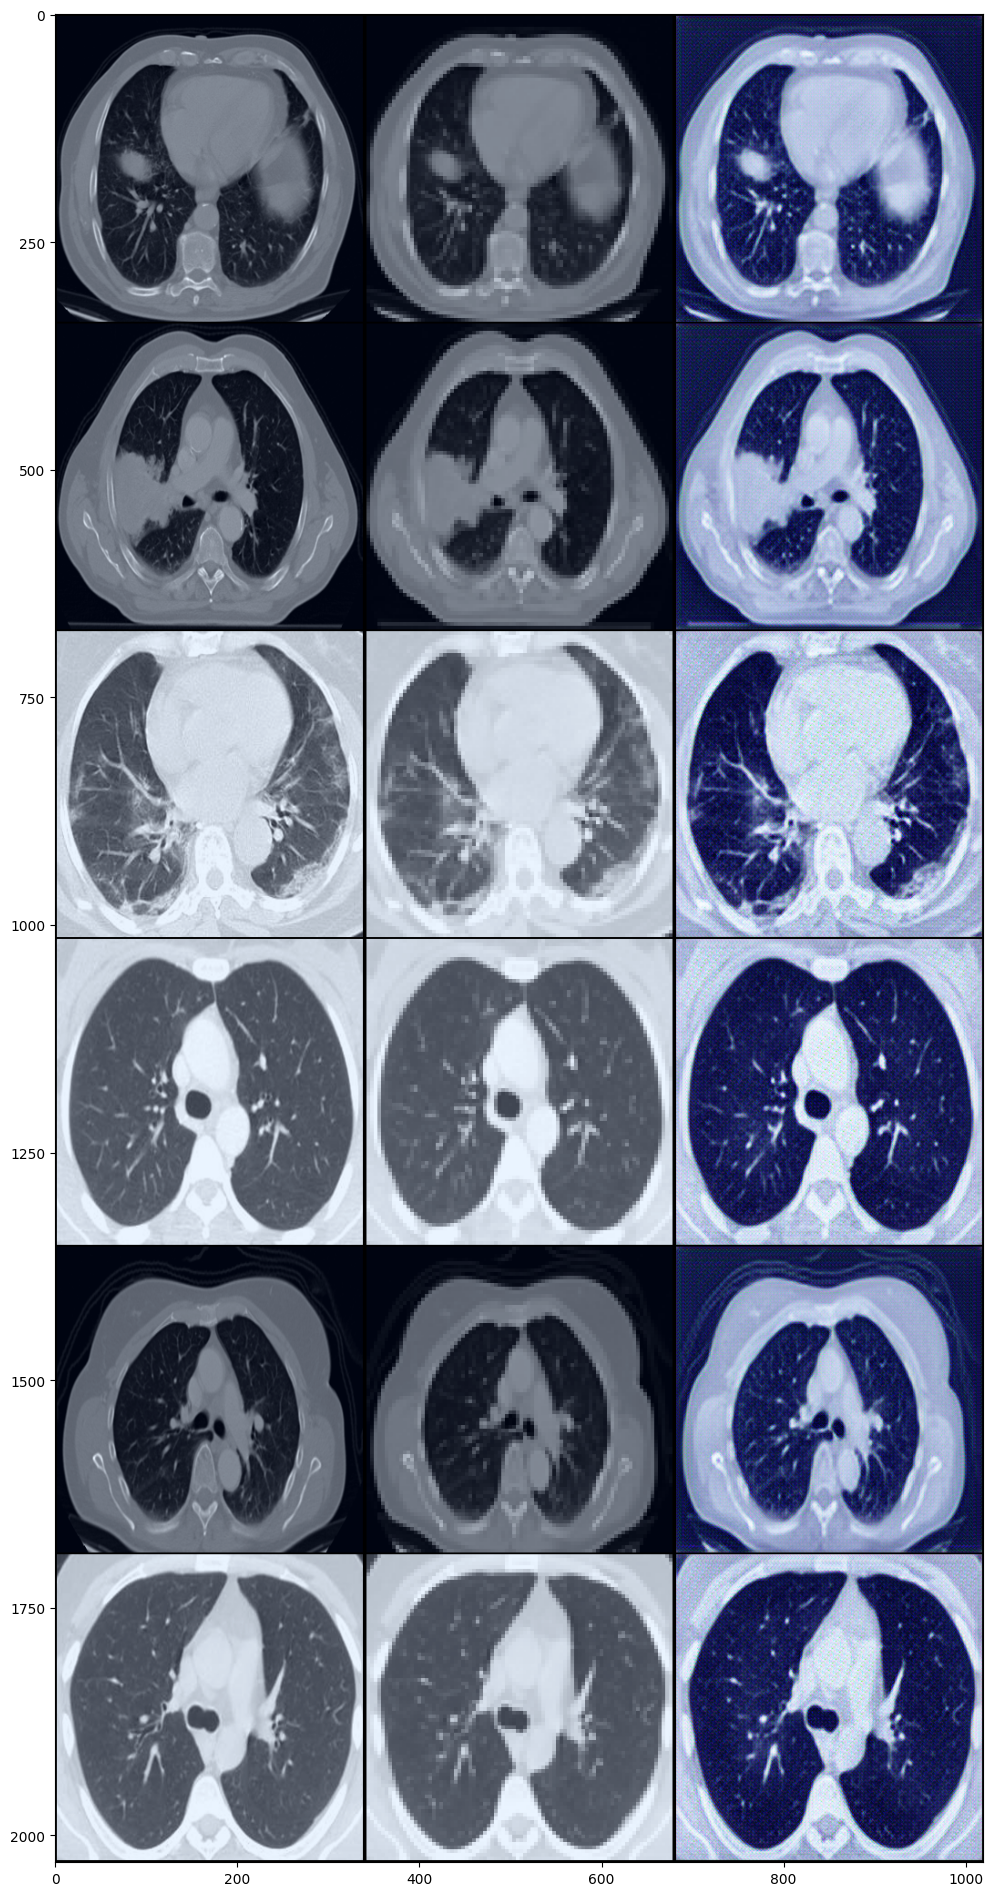

In [18]:
def show_image(image_name):
    img = cv2.imread(f'/kaggle/working/images/{image_name}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (12,24))
    plt.imshow(img)
    plt.show()
show_image(l[0])    

In [19]:
# show_image('2_7.png')

### Eval with PSNR

#### Code for testing other models
if you test other models, set this to True.

In [20]:
LOAD_PREV_MODEL = False
PATH = '/kaggle/input/personal-set/generator (3).pth'
device = torch.device('cuda')
if LOAD_PREV_MODEL:
    
    generator.load_state_dict(torch.load(PATH,map_location=device), strict=False)


#### Functions + Visualization

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning:

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



torch.Size([6, 3, 84, 84])
torch.Size([6, 3, 336, 336])
torch.Size([6, 3, 336, 336])
21.980280876159668
15.397423505783081
19.72932457923889
21.385841369628906
18.56376886367798
22.06583261489868


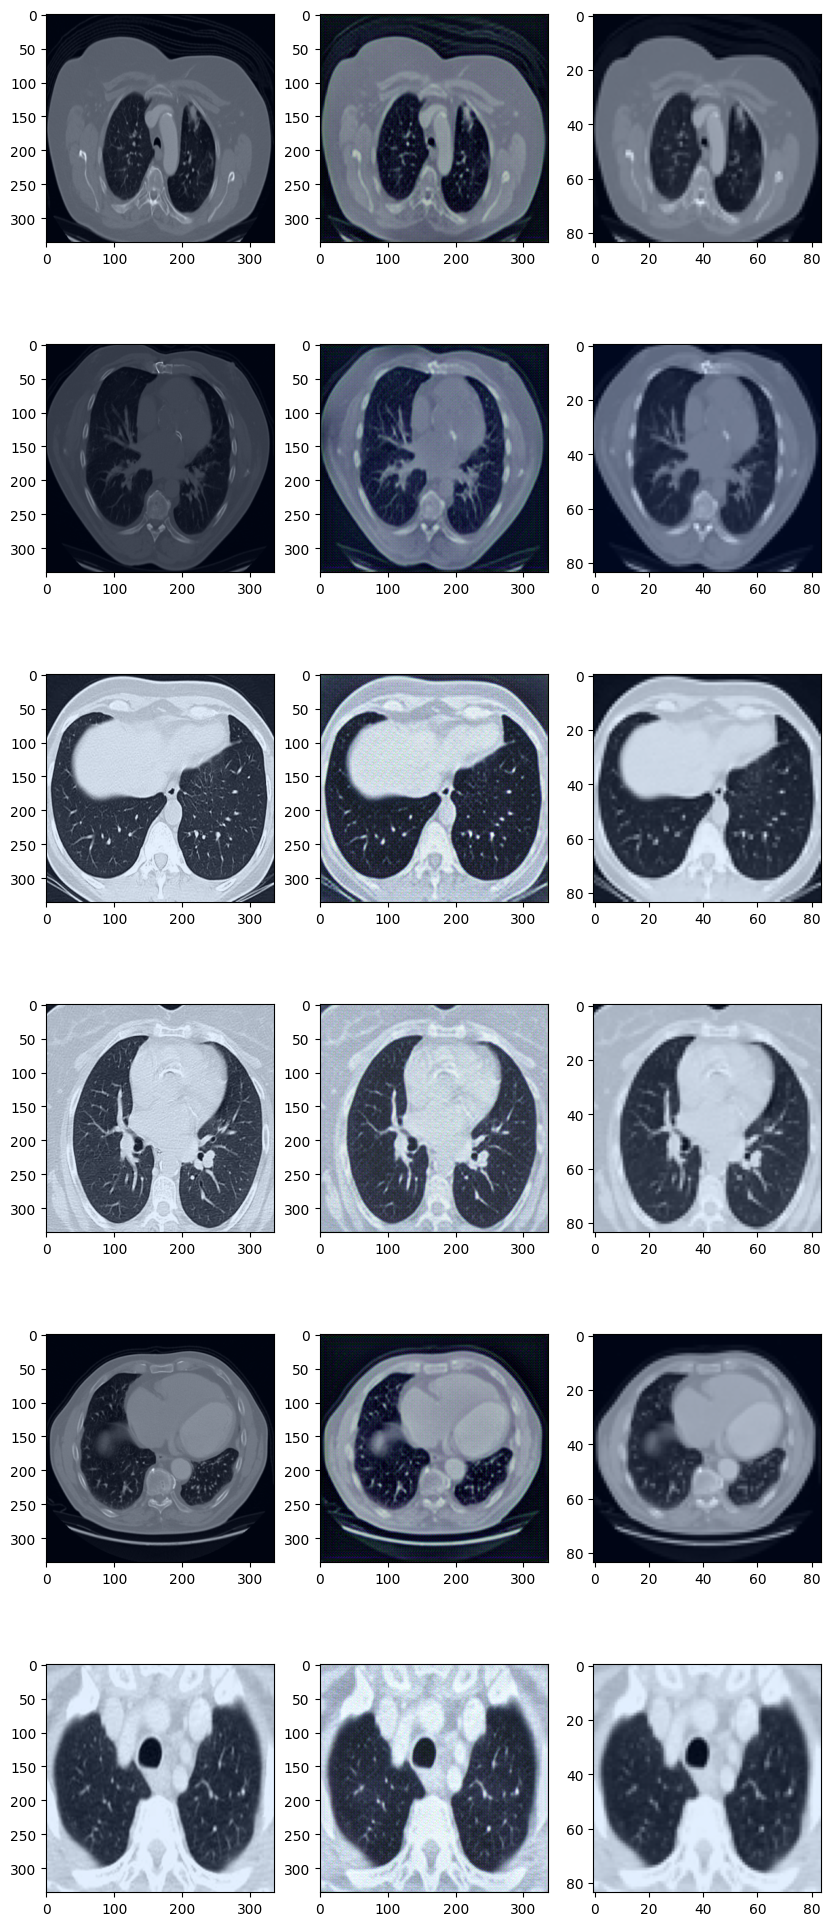

In [21]:
# tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))
def rescale_image_default(image):
    min_val,max_val = image.min(),image.max()
    
    return (image - min_val) / (max_val - min_val)

def image_dist(image):
    return image.mean((0,1)),image.std((0,1))

def rescale_image(image, target_mean, target_std):
    """
    Rescales an image to target mean and standard deviation for each color channel.

    Args:
        image (numpy.ndarray): Input image as a NumPy array.
        target_mean (tuple): Target mean values for each color channel (R, G, B).
        target_std (tuple): Target standard deviation values for each color channel (R, G, B).

    Returns:
        numpy.ndarray: Rescaled image as a NumPy array.
    """
    channel_means = np.mean(image, axis=(0, 1))  # Compute mean for each channel
    channel_stds = np.std(image, axis=(0, 1))  # Compute standard deviation for each channel
    rescaled_image = (image - channel_means) / channel_stds  # Standardize the image

    # Rescale each channel to the target mean and standard deviation
    for channel in range(3):  # Iterate over the three channels (R, G, B)
        rescaled_image[:, :, channel] = rescaled_image[:, :, channel] * target_std[channel] + target_mean[channel]

    return rescaled_image

def compute_psnr(original_array, generated_array):
    # Convert the arrays to float32
    original_array = np.array(original_array).astype(np.float32)
    generated_array = np.array(generated_array).astype(np.float32)

    # Calculate the mean squared error (MSE)
    mse = np.mean((original_array - generated_array) ** 2)

    # Calculate the maximum pixel value
    max_pixel_value = np.max(original_array)

    # Calculate the PSNR using the formula: PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
    psnr = 20 * np.log10(max_pixel_value) - 10 * np.log10(mse)

    return psnr

for batch_idx, imgs in enumerate(test_dataloader):
    fig = plt.figure(figsize = (10,25))
    # Configure model input
    imgs_lr = Variable(imgs["lr"].type(Tensor))
    imgs_hr = Variable(imgs["hr"].type(Tensor))
    print(imgs_lr.shape)
    print(imgs_hr.shape)
    # Adversarial ground truths
#     valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
#     fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
    gen_hr = generator(imgs_lr)
    print(gen_hr.shape)
    
    imgs_lr = imgs_lr.cpu().detach().numpy()
    imgs_lr = np.transpose(imgs_lr, (0, 2, 3, 1))
    gen_hr = gen_hr.cpu().detach().numpy()
    gen_hr = np.transpose(gen_hr, (0, 2, 3, 1))
    imgs_hr = imgs_hr.cpu().detach().numpy()
    imgs_hr = np.transpose(imgs_hr, (0, 2, 3, 1))
    for i in range(6):
        target_mean,target_std = image_dist(rescale_image_default(imgs_lr[i]))
        gen_hr[i] = rescale_image(gen_hr[i],target_mean,target_std)

        plt.subplot(6,3,3*i+1)
        plt.imshow(rescale_image_default(imgs_hr[i]))
        plt.subplot(6,3,3*i+2)
        plt.imshow(gen_hr[i])
        plt.subplot(6,3,3*i+3)
        plt.imshow(rescale_image_default(imgs_lr[i]))
#         print(image_dist(rescale_image_default(imgs_hr[i])))
        print(compute_psnr(rescale_image_default(imgs_hr[i]),gen_hr[i]))
    break
plt.show()

torch.Size([6, 3, 84, 84])
torch.Size([6, 3, 336, 336])
torch.Size([6, 3, 336, 336])
15.397423505783081
20.863866806030273
21.161060333251953
18.172876834869385
22.77879238128662
19.72932457923889


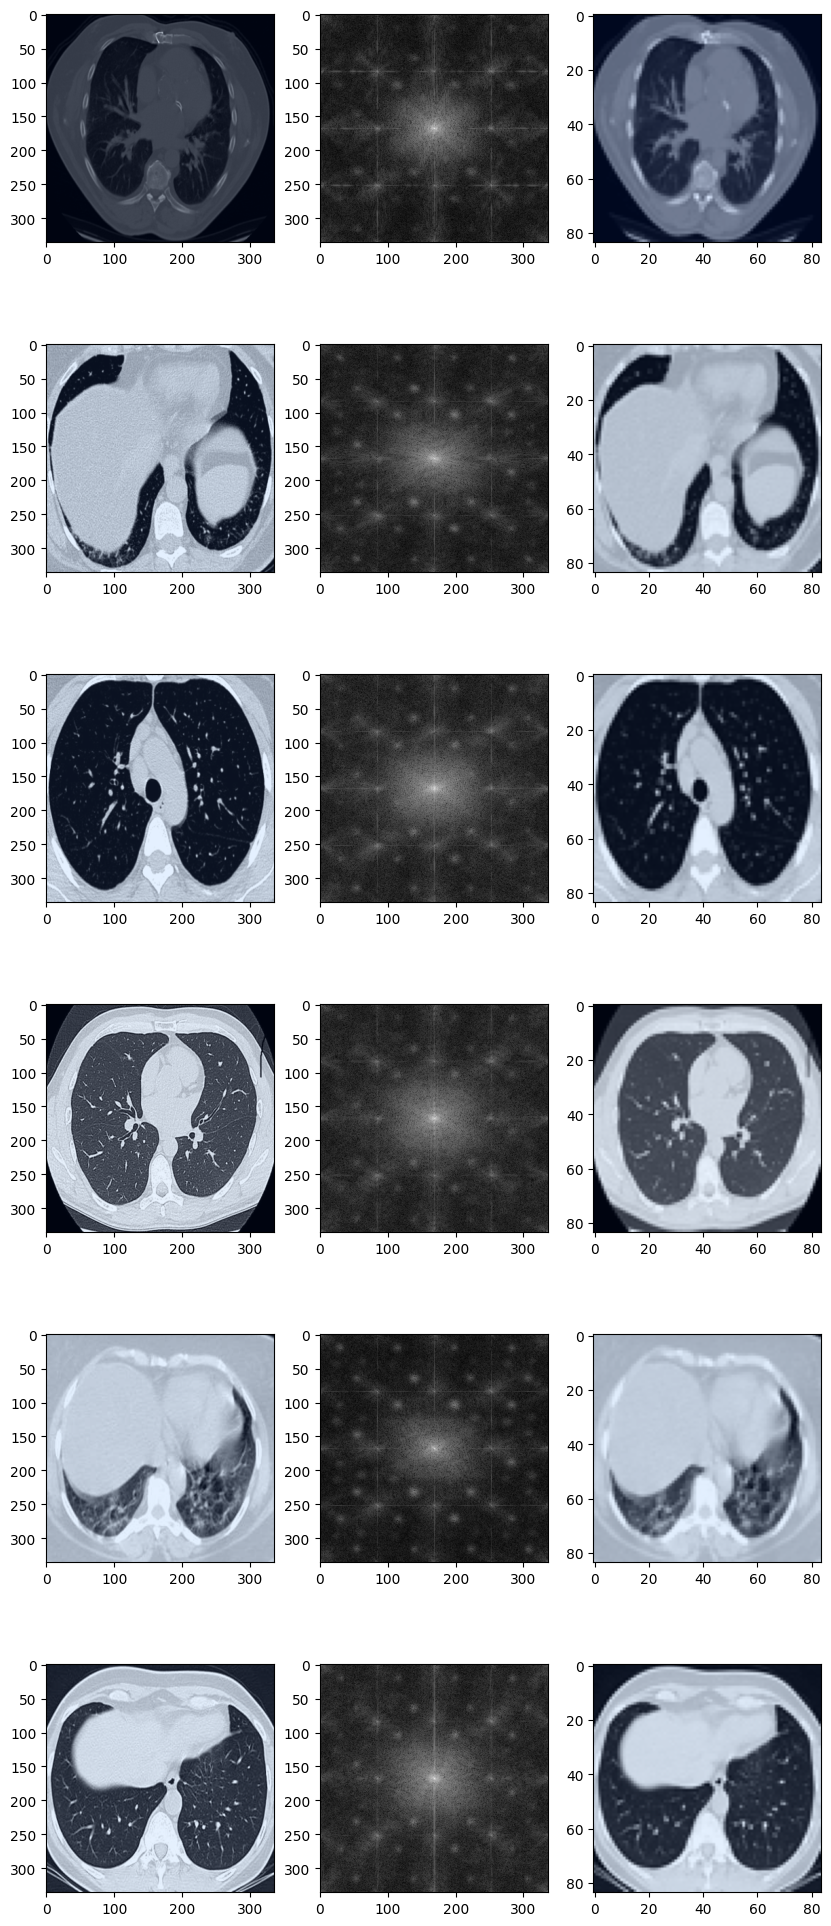

In [22]:
from scipy.fft import fft2,fftshift,ifftshift,ifft2
import cv2 

def spectrum(image,to_plot = True):
    gray = image.mean(axis = 2)
    F = fft2(gray)
    F = fftshift(F)
    if to_plot:
        return np.log(1+np.abs(F))
    return F
fig = plt.figure(figsize = (10,25))
for batch_idx, imgs in enumerate(test_dataloader):
    # Configure model input
    imgs_lr = Variable(imgs["lr"].type(Tensor))
    imgs_hr = Variable(imgs["hr"].type(Tensor))
    print(imgs_lr.shape)
    print(imgs_hr.shape)
    # Adversarial ground truths
#     valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
#     fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
    gen_hr = generator(imgs_lr)
    print(gen_hr.shape)
    
    imgs_lr = imgs_lr.cpu().detach().numpy()
    imgs_lr = np.transpose(imgs_lr, (0, 2, 3, 1))
    gen_hr = gen_hr.cpu().detach().numpy()
    gen_hr = np.transpose(gen_hr, (0, 2, 3, 1))
    imgs_hr = imgs_hr.cpu().detach().numpy()
    imgs_hr = np.transpose(imgs_hr, (0, 2, 3, 1))
    Fs = [None]*6
    for i in range(6):
        target_mean,target_std = image_dist(rescale_image_default(imgs_lr[i]))
        gen_hr[i] = rescale_image(gen_hr[i],target_mean,target_std)
        Fs[i] = spectrum(gen_hr[i])

        plt.subplot(6,3,3*i+1)
        plt.imshow(rescale_image_default(imgs_hr[i]))
        plt.subplot(6,3,3*i+2)
        plt.imshow(Fs[i],cmap = 'gray')
        plt.subplot(6,3,3*i+3)
        plt.imshow(rescale_image_default(imgs_lr[i]))
#         print(image_dist(rescale_image_default(imgs_hr[i])))
        print(compute_psnr(rescale_image_default(imgs_hr[i]),gen_hr[i]))
    break
plt.show()

torch.Size([6, 3, 84, 84])
torch.Size([6, 3, 336, 336])
torch.Size([6, 3, 336, 336])
14.923292398452759
22.160022258758545
21.360561847686768
20.113580226898193
15.232999324798584
22.971255779266357


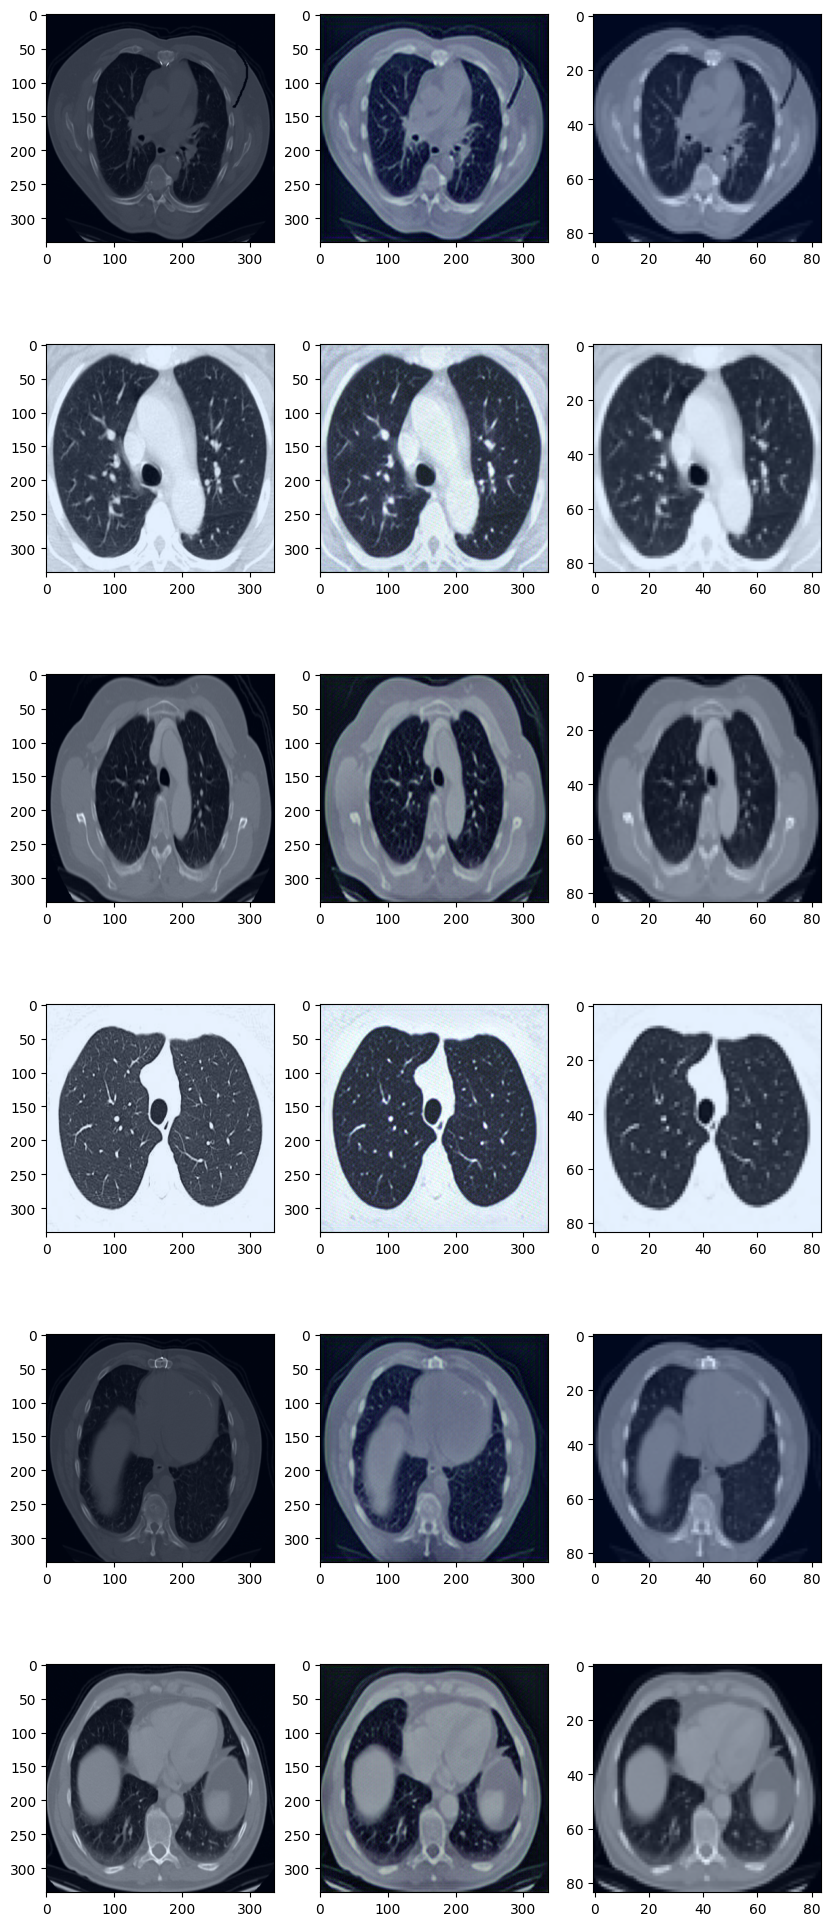

In [23]:
fig = plt.figure(figsize = (10,25))

def denoise_fourier(image):
    new_image = np.zeros_like(image)
    for i in range(3):
        image_chan = image[:,:,i]
        F = fft2(image_chan)
        F2 = fftshift(F)
        
        F2[75:95] = 0
        F2[:,75:75] = 0

        F2[245:265] = 0
        F2[:,245:265] = 0
        rest_chan = np.real(ifft2(ifftshift(F2)))
        new_image[:,:,i] = rest_chan
    return new_image
for batch_idx, imgs in enumerate(test_dataloader):
    # Configure model input
    imgs_lr = Variable(imgs["lr"].type(Tensor))
    imgs_hr = Variable(imgs["hr"].type(Tensor))
    print(imgs_lr.shape)
    print(imgs_hr.shape)
    # Adversarial ground truths
#     valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
#     fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
    gen_hr = generator(imgs_lr)
    print(gen_hr.shape)
    
    imgs_lr = imgs_lr.cpu().detach().numpy()
    imgs_lr = np.transpose(imgs_lr, (0, 2, 3, 1))
    gen_hr = gen_hr.cpu().detach().numpy()
    gen_hr = np.transpose(gen_hr, (0, 2, 3, 1))
    imgs_hr = imgs_hr.cpu().detach().numpy()
    imgs_hr = np.transpose(imgs_hr, (0, 2, 3, 1))
    Fs = [None]*6
    for i in range(6):
        target_mean,target_std = image_dist(rescale_image_default(imgs_lr[i]))
        gen_hr[i] = rescale_image(gen_hr[i],target_mean,target_std)
        Fs[i] = denoise_fourier(gen_hr[i])

        plt.subplot(6,3,3*i+1)
        plt.imshow(rescale_image_default(imgs_hr[i]))
        plt.subplot(6,3,3*i+2)
        plt.imshow(Fs[i],cmap = 'gray')
        plt.subplot(6,3,3*i+3)
        plt.imshow(rescale_image_default(imgs_lr[i]))
#         print(image_dist(rescale_image_default(imgs_hr[i])))
        print(compute_psnr(rescale_image_default(imgs_hr[i]),gen_hr[i]))
    break
plt.show()

#### PSNR after rescaling

In [24]:
psnr_list = []
for batch_idx, imgs in tqdm(enumerate(test_dataloader)):
    
    # Configure model input
    imgs_lr = Variable(imgs["lr"].type(Tensor))
    imgs_hr = Variable(imgs["hr"].type(Tensor))
#     print(imgs_lr.shape)
#     print(imgs_hr.shape)
    # Adversarial ground truths
#     valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
#     fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
    gen_hr = generator(imgs_lr)
#     print(gen_hr.shape)
    
    imgs_lr = imgs_lr.cpu().detach().numpy()
    imgs_lr = np.transpose(imgs_lr, (0, 2, 3, 1))
    gen_hr = gen_hr.cpu().detach().numpy()
    gen_hr = np.transpose(gen_hr, (0, 2, 3, 1))
    imgs_hr = imgs_hr.cpu().detach().numpy()
    imgs_hr = np.transpose(imgs_hr, (0, 2, 3, 1))
    for i in range(imgs_hr.shape[0]):
        target_mean,target_std = image_dist(rescale_image_default(imgs_lr[i]))
        gen_hr[i] = rescale_image(gen_hr[i],target_mean,target_std)


#         print(image_dist(rescale_image_default(imgs_hr[i])))
        psnr = compute_psnr(rescale_image_default(imgs_hr[i]),gen_hr[i])
        psnr_list.append(psnr)
print(np.mean(psnr_list))

0it [00:00, ?it/s]

20.54137420654297


#### PSNR after rescaling and denoising

In [25]:
psnr_list = []
for batch_idx, imgs in tqdm(enumerate(test_dataloader)):
    
    # Configure model input
    imgs_lr = Variable(imgs["lr"].type(Tensor))
    imgs_hr = Variable(imgs["hr"].type(Tensor))
#     print(imgs_lr.shape)
#     print(imgs_hr.shape)
    # Adversarial ground truths
#     valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
#     fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
    gen_hr = generator(imgs_lr)
#     print(gen_hr.shape)
    
    imgs_lr = imgs_lr.cpu().detach().numpy()
    imgs_lr = np.transpose(imgs_lr, (0, 2, 3, 1))
    gen_hr = gen_hr.cpu().detach().numpy()
    gen_hr = np.transpose(gen_hr, (0, 2, 3, 1))
    imgs_hr = imgs_hr.cpu().detach().numpy()
    imgs_hr = np.transpose(imgs_hr, (0, 2, 3, 1))
    for i in range(imgs_hr.shape[0]):
        target_mean,target_std = image_dist(rescale_image_default(imgs_lr[i]))
        gen_hr[i] = rescale_image(gen_hr[i],target_mean,target_std)


#         print(image_dist(rescale_image_default(imgs_hr[i])))
        psnr = compute_psnr(denoise_fourier(rescale_image_default(imgs_hr[i])),gen_hr[i])
        psnr_list.append(psnr)
print(np.mean(psnr_list))

0it [00:00, ?it/s]

20.755883241382737


In [26]:
imgs_hr.max(),imgs_hr.min()

(2.64, -2.117904)